# Обучение char-level языковой модели с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split


from collections import Counter


import seaborn
seaborn.set(palette='summer')

In [3]:
#Работа с пунктуацией
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gosha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [6]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0", trust_remote_code=True)

gazeta_train.jsonl:   0%|          | 0.00/471M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [7]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [210]:
sentence

'журналисты утверждают, что такую идею уже обсуждали на экстренных заседаниях правительственного комитета по безопасности.'

In [8]:
len(sentences)

122237

Словарь состоит из различных символов, причём как букв, так и цифр.

In [10]:
chars = Counter()

for sentence in tqdm(sentences):
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 500

for char, cnt in chars.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [12]:
len(vocab)

86

In [13]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [211]:
sentences[0]

'красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны.'

In [14]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

## Архитектура модели

In [17]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

## Train loop

In [18]:
def evaluate(model, criterion) -> float:
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits,
                batch['target_ids'].flatten()
                )
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [78]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [79]:
num_epoch = 200
losses = []
perplexities = []

for epoch in tqdm(range(num_epoch)):
    epoch_losses = []
    model.train()
    for batch in train_dataloader: #tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

  0%|          | 0/200 [00:00<?, ?it/s]

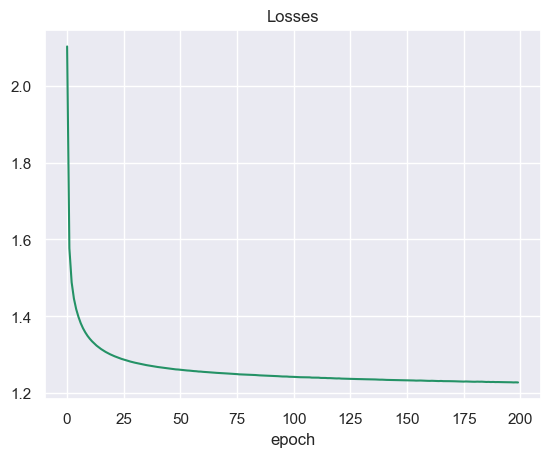

In [80]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

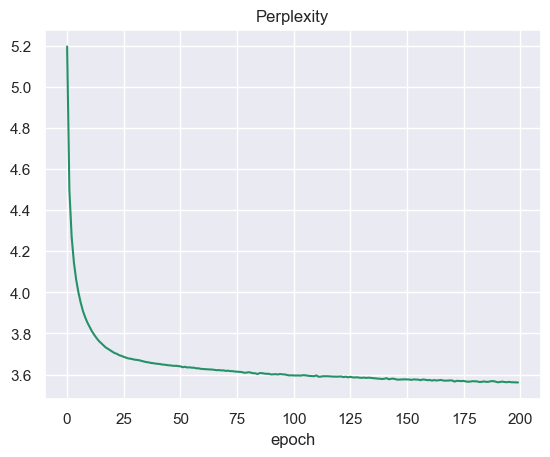

In [81]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Generation

In [192]:
softmax = torch.nn.Softmax(0)

In [205]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    #fig, axs = plt.subplots(2, 1, figsize = (40, 10), constrained_layout = True, dpi = 600)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len): #range(max_seq_len):
            next_char_distribution = model(input_ids)[-1] #[-1] - выбор последнего тензора из батча, который создаётся ОДНИМ предложением

            #dist = pd.DataFrame([[ind2char[x], y] for x, y in enumerate(softmax(next_char_distribution).cpu().numpy())])
            
            
            #print(softmax(next_char_distribution))
            next_char = next_char_distribution.squeeze().argmax()
            #print('Selected char', next_char)
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
            #sns.barplot(data = dist, x = dist[0], y = dist[1], ax = axs[i])
            #axs[i].set_ylabel(ind2char[next_char.item()])
            #axs[i].tick_params(axis='x', labelrotation=45)

            if next_char.item() == char2ind['<eos>']:
                break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])
    plt.show()
    return words

In [209]:
generate_sequence(model, starting_seq='краснодврский краевой суд')

'<bos>краснодврский краевой суд подчеркнул, что не понимаю, что в свою очередь произошла в состав россии в своем твиттере.<eos>'

In [173]:
pd.DataFrame([['a', 1], ['B', 2]])

,0,1
0,a,1
1,B,2


In [174]:
import pandas as pd
import seaborn as sns

In [212]:
torch.save(model.state_dict(), 'CharLLM_Z.pt')